In [1]:
#### MOUNT DRIVE TO USE AS A EXTRENAL STORAGE ####
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# magic command %cd - to move into directories#
%cd /content/drive/My Drive/PERSONALITY

/content/drive/My Drive/PERSONALITY


In [3]:
!ls

glove.6B.100d.txt  glove.6B.50d.txt  model_lstm.h5  PersonalityPredictMBTI.py
glove.6B.200d.txt  glove.6B.zip      model_rnn.h5
glove.6B.300d.txt  mbti_1.csv	     Myquora.txt


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import string
import seaborn as sns
import random
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GRU, Dense, Dot, multiply, add, LSTM, merge
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.models import Model
from keras.layers.core import *
from keras import backend as K
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import jaccard_score, cohen_kappa_score, multilabel_confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **DATA SET ANALYSIS**

In [5]:
data_set = pd.read_csv("mbti_1.csv")
data_set.head() # to display the first 5 rows

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
data_set.tail() # to display the last 5 rows

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [7]:
data_set.shape

(8675, 2)

In [8]:
df = pd.read_csv("mbti_1.csv")


In [9]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [10]:
dt = pd.read_csv("mbti_1.csv")
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

dt['Words per comment'] = dt['posts'].apply(lambda x: len(x.split())/50)
dt['Variance of word counts'] = dt['posts'].apply(lambda x: var_row(x))
dt.head(15)

,type,posts,Words per comment,Variance of word counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.290000
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.475600
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.690000
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.832400
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.457600
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,29.82,97.720000
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",26.58,151.366400
7,INTJ,'I tend to build up a collection of things on ...,24.46,174.766400
8,INFJ,"I'm not sure, that's a good question. The dist...",14.76,207.112400
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,24.66,145.670400


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 39.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/pyth

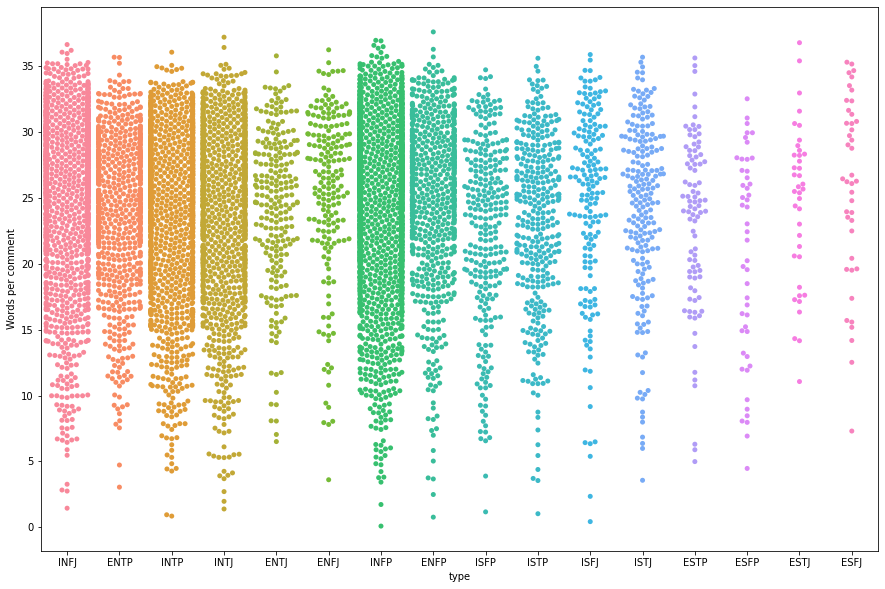

In [11]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "Words per comment", data=dt)

In [12]:
df.groupby('type').agg({'type':'count'})

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


Text(0.5, 1.0, 'Number of persons per personality')

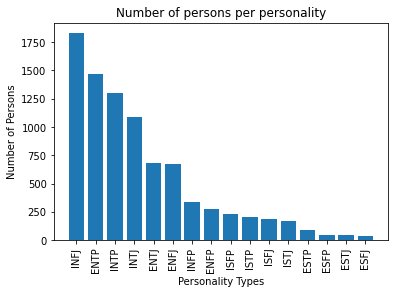

In [13]:
y=df['type'].value_counts()
x=df['type'].unique()
plt.bar(x, y, width=0.8, bottom=None, align='center', data=df)
plt.xticks(rotation='vertical')
plt.xlabel('Personality Types')
plt.ylabel('Number of Persons')
plt.title('Number of persons per personality')

## **DATA PROCESSING**

In [14]:
stop_words = set()
def stopwords(text): 
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])

def process_text(string):
  text =re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ',string) #remove url
  text =re.sub('[\n]',' ',text) # remove newline character
  text =re.sub('[^a-zA-Z]',' ',text.lower()) # remove non alphabetic characters
  #text =stopwords(text) # remove stopwords 
  return text

In [15]:
# Data Cleaning 
processed_data=[]
for i in range(len(data_set)):
  t=[]
  t.append(data_set['type'][i])
  t.append(process_text(data_set['posts'][i]))
  processed_data.append(t)

In [16]:
processed_data_array=np.array(processed_data)
print(processed_data_array.shape) #(8675, 2)

(8675, 2)


In [17]:
processed_data_array

array([['INFJ',
        '   and intj moments     sportscenter not top ten plays     pranks   what has been the most life changing experience in your life           on repeat for most of today    may the perc experience immerse you    the last thing my infj friend posted on his facebook before committing suicide the next day  rest in peace      enfj   sorry to hear of your distress  it s only natural for a relationship to not be perfection all the time in every moment of existence  try to figure the hard times as times of growth  as                               welcome and stuff       game  set  match    prozac  wellbrutin  at least thirty minutes of moving your legs  and i don t mean moving them while sitting in your same desk chair   weed in moderation  maybe try edibles as a healthier alternative      basically come up with three items you ve determined that each type  or whichever types you want to do  would more than likely use  given each types  cognitive functions and whatnot  w

In [18]:
X=processed_data_array[:,1]
y=processed_data_array[:,0]

In [19]:
X

array(['   and intj moments     sportscenter not top ten plays     pranks   what has been the most life changing experience in your life           on repeat for most of today    may the perc experience immerse you    the last thing my infj friend posted on his facebook before committing suicide the next day  rest in peace      enfj   sorry to hear of your distress  it s only natural for a relationship to not be perfection all the time in every moment of existence  try to figure the hard times as times of growth  as                               welcome and stuff       game  set  match    prozac  wellbrutin  at least thirty minutes of moving your legs  and i don t mean moving them while sitting in your same desk chair   weed in moderation  maybe try edibles as a healthier alternative      basically come up with three items you ve determined that each type  or whichever types you want to do  would more than likely use  given each types  cognitive functions and whatnot  when left by      

In [20]:
print(y[1:20])

['ENTP' 'INTP' 'INTJ' 'ENTJ' 'INTJ' 'INFJ' 'INTJ' 'INFJ' 'INTP' 'INFJ'
 'ENFJ' 'INFJ' 'INTJ' 'INTP' 'INTP' 'INFJ' 'INFP' 'INFJ' 'INFP']


In [21]:
# Label Encoding of the actual labels 
label_encoder = preprocessing.LabelEncoder()
#label output/ MBTI labels
label_encoder.fit(y)
labels = label_encoder.transform(y) 
labels = np.expand_dims(labels, axis=1)
print(labels[1:20]); print(y[1:20])

[[ 3]
 [11]
 [10]
 [ 2]
 [10]
 [ 8]
 [10]
 [ 8]
 [11]
 [ 8]
 [ 0]
 [ 8]
 [10]
 [11]
 [11]
 [ 8]
 [ 9]
 [ 8]
 [ 9]]
['ENTP' 'INTP' 'INTJ' 'ENTJ' 'INTJ' 'INFJ' 'INTJ' 'INFJ' 'INTP' 'INFJ'
 'ENFJ' 'INFJ' 'INTJ' 'INTP' 'INTP' 'INFJ' 'INFP' 'INFJ' 'INFP']


In [22]:
print(np.unique(labels))
print(np.unique(y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [23]:
np.random.seed(1000)
most_freq_words = 10000
MAX_LENGTH_FOR_KERAS_RNN = 40
embedding_vector_length = 300
oov_token = '<UNK>'

In [24]:
## Tokenization of text for generation of word embeddings
tokenizer = Tokenizer(num_words=most_freq_words, oov_token=oov_token)
tokenizer.fit_on_texts(X)

In [25]:
word_index = tokenizer.word_index
vocab_size=len(word_index)
print('Original Size of Vocabulary: ',vocab_size)

Original Size of Vocabulary:  96945


In [26]:
word_index = {e:i for e,i in word_index.items() if i <= most_freq_words} # reduce the Size of Vocabulary
print('New Size of Vocabulary: ',len(word_index))

New Size of Vocabulary:  10000


In [27]:
## text is converted into indexes and padding is done to get a fixed size input
text_seq = tokenizer.texts_to_sequences(X)

#maxlen = max([len(i) for i in text_seq])
#MAX_LENGTH_FOR_KERAS_RNN = maxlen

x = pad_sequences(text_seq, maxlen=MAX_LENGTH_FOR_KERAS_RNN)

In [28]:
#split the data set into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.3, random_state=42)

In [29]:
#Data Summary
print('Total of the Dataset: ',len(processed_data_array))
print('No. of Training dataset: ',len(X_train))
print('No. of Test dataset: ',len(X_test))
print('Classes: ',data_set['type'].nunique())

Total of the Dataset:  8675
No. of Training dataset:  6072
No. of Test dataset:  2603
Classes:  16


## **MODEL CREATION**

In [30]:
#Load pretrained word vectors from Glove # Word embeddings for the inputs
glove_file = open('glove.6B.300d.txt', encoding="utf8") # load the GloVe word vectors

In [31]:
word_embeddings_glove = {} #embeddings_dictionary : create a dictionary where words are the keys and the corresponding vectors are values

for line in glove_file:
  values = line.split()
  word = values[0] # values[0] will give position of the word in glove_file
  vec = np.asarray(values[1:], dtype='float32') # "values[1:]" will give vector representation of the word at position "values[0]"
  word_embeddings_glove[word] = vec # assign word as a key in dictonarary and vector of that word(key) as value
print('Found %s word vectors.' % len(word_embeddings_glove))

Found 400000 word vectors.


In [32]:
# Creating an embedding matrix that contains the vectors of the words in the MBTI dataset
word_embeddings_mbti = np.zeros((most_freq_words, embedding_vector_length))

for word, i in word_index.items():
  if i < most_freq_words:
    embedding_vector = word_embeddings_glove.get(word)
    if embedding_vector is not None:
        word_embeddings_mbti[i] = embedding_vector

In [33]:
print('Shape of embeddings matrix: ',word_embeddings_mbti.shape)

Shape of embeddings matrix:  (10000, 300)


**LSTM WITHOUT ATTENTION LAYER**




In [34]:
def lstm_model():
  
  input_sequences = Input(shape=(MAX_LENGTH_FOR_KERAS_RNN,))
  embedding_layer = Embedding(input_dim=most_freq_words,
                                output_dim=embedding_vector_length,
                                input_length=MAX_LENGTH_FOR_KERAS_RNN,
                                trainable =True,
                                mask_zero =True,
                                weights=[word_embeddings_mbti])
       
  embout = embedding_layer(input_sequences)
  lstmout = LSTM(embedding_vector_length, dropout=0.2, recurrent_dropout=0.2)(embout)
  outputs = Dense(16, activation='softmax')(lstmout) #sigmoid, relu, softmax 
  model = Model(inputs=input_sequences, outputs=outputs)
  optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # lr=0.001,0.01 , beta_1=0.9, beta_2=0.999
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model_lstm = lstm_model()
model_lstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 300)           3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 16)                4816      
Total params: 3,726,016
Trainable params: 3,726,016
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [46]:
history_model_lstm = model_lstm.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
76/76 [==============================] - 31s 340ms/step - loss: 2.3204 - accuracy: 0.1931 - val_loss: 2.3001 - val_accuracy: 0.1786
Epoch 2/10
76/76 [==============================] - 25s 329ms/step - loss: 2.2313 - accuracy: 0.2394 - val_loss: 2.3056 - val_accuracy: 0.1909
Epoch 3/10
76/76 [==============================] - 24s 322ms/step - loss: 2.1312 - accuracy: 0.2905 - val_loss: 2.3321 - val_accuracy: 0.1852
Epoch 4/10
76/76 [==============================] - 25s 327ms/step - loss: 1.9552 - accuracy: 0.3702 - val_loss: 2.4212 - val_accuracy: 0.1885
Epoch 5/10
76/76 [==============================] - 24s 321ms/step - loss: 1.6482 - accuracy: 0.4820 - val_loss: 2.6724 - val_accuracy: 0.1819
Epoch 6/10
76/76 [==============================] - 25s 333ms/step - loss: 1.3045 - accuracy: 0.5917 - val_loss: 2.9159 - val_accuracy: 0.1580
Epoch 7/10
76/76 [==============================] - 24s 320ms/step - loss: 0.9764 - accuracy: 0.7000 - val_loss: 3.2425 - val_accuracy: 0.1597

In [39]:
def plot(model_history):
  acc=model_history.history['accuracy']
  val_acc=model_history.history['val_accuracy']
  loss=model_history.history['loss']
  val_loss=model_history.history['val_loss']
  epochs=range(len(acc)) # Get number of epochs
  plt.plot(epochs, acc, 'r')
  plt.plot(epochs, val_acc, 'b')
  plt.title('Training and validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])
  plt.figure()
  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'b')
  plt.title('Training and validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])
  plt.figure()


In [40]:
def prediction(model):

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_pred_list =[]
  y_test_pred_list = []

  for i in y_train_pred:
    max_index=np.argmax(i)
    y_train_pred_list.append(max_index)

  for i in y_test_pred:
    max_index=np.argmax(i)
    y_test_pred_list.append(max_index)

  return y_train_pred_list, y_test_pred_list


LSTM without attention layer model evaluation on training data:
Accuracy Score:  0.8155467720685112
cohen_kappa_score: 0.7877489287401322
Precision:  0.8155467720685112
Recall: 0.8155467720685112
F1 score: 0.8155467720685112
LSTM without attention layer model evaluation on test data:
Accuracy Score:  0.17479830964271995
cohen_kappa_score: 0.041836057437973584
Precision:  0.17479830964271995
Recall: 0.17479830964271995
F1 score: 0.17479830964271995


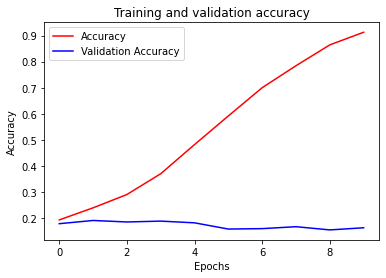

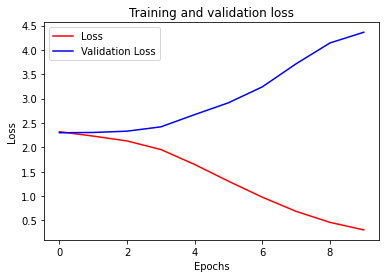

<Figure size 432x288 with 0 Axes>

In [53]:
plot(history_model_lstm)
train_pred ,test_pred = prediction(model_lstm)
print("LSTM without attention layer model evaluation on training data:")
print("Accuracy Score: ",accuracy_score(y_train, train_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_train, train_pred))
print("Precision: ",precision_score(y_train, train_pred,average='micro'))
print("Recall:",recall_score(y_train, train_pred,average='micro'))
print("F1 score:",f1_score(y_train, train_pred,average='micro'))

print("LSTM without attention layer model evaluation on test data:")
print("Accuracy Score: ",accuracy_score(y_test, test_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_test, test_pred))
print("Precision: ",precision_score(y_test, test_pred,average='micro'))
print("Recall:",recall_score(y_test, test_pred,average='micro'))
print("F1 score:",f1_score(y_test, test_pred,average='micro'))

In [54]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
print("LSTM without attention layer:\nMultilabel Confusion Matrix:")
multilabel_confusion_matrix(y_test, test_pred,labels=np.unique(y_test))

LSTM without attention layer:
Multilabel Confusion Matrix:


array([[[2508,   39],
        [  55,    1]],

       [[2263,  144],
        [ 184,   12]],

       [[2489,   56],
        [  57,    1]],

       [[2136,  266],
        [ 170,   31]],

       [[2579,   14],
        [  10,    0]],

       [[2580,   14],
        [   9,    0]],

       [[2585,    1],
        [  17,    0]],

       [[2553,   25],
        [  25,    0]],

       [[1696,  473],
        [ 320,  114]],

       [[1633,  404],
        [ 404,  162]],

       [[2037,  255],
        [ 264,   47]],

       [[1873,  326],
        [ 327,   77]],

       [[2500,   42],
        [  59,    2]],

       [[2490,   29],
        [  83,    1]],

       [[2523,   10],
        [  70,    0]],

       [[2452,   50],
        [  94,    7]]])

In [38]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    """if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)"""

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return ax

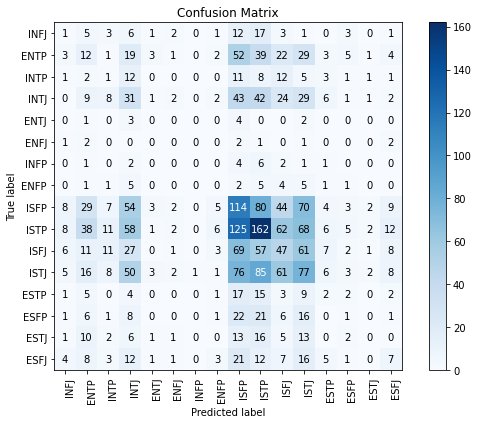

In [58]:
plot_confusion_matrix(y_test, test_pred, classes=df['type'].unique(),title='Confusion Matrix')

**GRU WITHOUT ATTENTION LAYER**

In [35]:
def gru_model():

  input_sequences = Input(shape=(MAX_LENGTH_FOR_KERAS_RNN,))
  embedding_layer = Embedding(input_dim=most_freq_words,
                                output_dim=embedding_vector_length,
                                input_length=MAX_LENGTH_FOR_KERAS_RNN,
                                trainable =True,
                                mask_zero =True,
                                weights=[word_embeddings_mbti])     
  embout = embedding_layer(input_sequences)
  gruout = GRU(embedding_vector_length, dropout=0.2)(embout)
  outputs = Dense(16, activation='softmax')(gruout) #sigmoid, relu, softmax 
  model = Model(inputs=input_sequences, outputs=outputs)
  optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # 0.001
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model_gru = gru_model()
model_gru.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 300)           3000000   
_________________________________________________________________
gru (GRU)                    (None, 300)               541800    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4816      
Total params: 3,546,616
Trainable params: 3,546,616
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
history_model_gru = model_gru.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
76/76 [==============================] - 13s 82ms/step - loss: 2.3414 - accuracy: 0.1911 - val_loss: 2.3189 - val_accuracy: 0.1728
Epoch 2/10
76/76 [==============================] - 2s 32ms/step - loss: 2.1984 - accuracy: 0.2493 - val_loss: 2.3329 - val_accuracy: 0.1934
Epoch 3/10
76/76 [==============================] - 2s 33ms/step - loss: 2.0701 - accuracy: 0.3066 - val_loss: 2.3954 - val_accuracy: 0.1687
Epoch 4/10
76/76 [==============================] - 2s 29ms/step - loss: 1.8465 - accuracy: 0.4062 - val_loss: 2.5253 - val_accuracy: 0.2025
Epoch 5/10
76/76 [==============================] - 2s 30ms/step - loss: 1.5091 - accuracy: 0.5168 - val_loss: 2.8092 - val_accuracy: 0.1786
Epoch 6/10
76/76 [==============================] - 2s 31ms/step - loss: 1.1040 - accuracy: 0.6477 - val_loss: 3.1599 - val_accuracy: 0.1712
Epoch 7/10
76/76 [==============================] - 2s 31ms/step - loss: 0.7295 - accuracy: 0.7803 - val_loss: 3.6824 - val_accuracy: 0.1720
Epoch 8/10
7

GRU without attention layer model evaluation on training data:
Accuracy Score:  0.8316864295125165
cohen_kappa_score: 0.8063501499513893
Precision:  0.8316864295125165
Recall: 0.8316864295125165
F1 score: 0.8316864295125165
GRU without attention layer model evaluation on test data:
Accuracy Score:  0.1867076450249712
cohen_kappa_score: 0.05155039653621596
Precision:  0.1867076450249712
Recall: 0.1867076450249712
F1 score: 0.18670764502497117


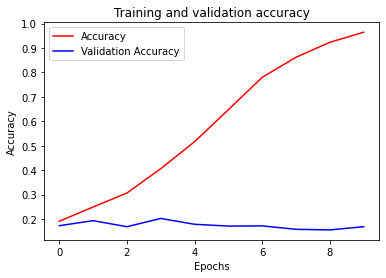

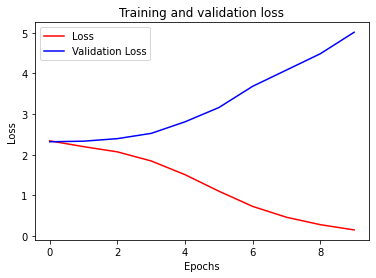

<Figure size 432x288 with 0 Axes>

In [41]:
train_pred ,test_pred ="","" # reset variables
plot(history_model_gru)
train_pred ,test_pred = prediction(model_gru)
print("GRU without attention layer model evaluation on training data:")
print("Accuracy Score: ",accuracy_score(y_train, train_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_train, train_pred))
print("Precision: ",precision_score(y_train, train_pred,average='micro'))
print("Recall:",recall_score(y_train, train_pred,average='micro'))
print("F1 score:",f1_score(y_train, train_pred,average='micro'))

print("GRU without attention layer model evaluation on test data:")
print("Accuracy Score: ",accuracy_score(y_test, test_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_test, test_pred))
print("Precision: ",precision_score(y_test, test_pred,average='micro'))
print("Recall:",recall_score(y_test, test_pred,average='micro'))
print("F1 score:",f1_score(y_test, test_pred,average='micro'))

In [42]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
print("GRU without attention layer:\nMultilabel Confusion Matrix:")
multilabel_confusion_matrix(y_test, test_pred,labels=np.unique(y_test))

GRU without attention layer:
Multilabel Confusion Matrix:


array([[[2511,   36],
        [  56,    0]],

       [[2245,  162],
        [ 174,   22]],

       [[2507,   38],
        [  58,    0]],

       [[2205,  197],
        [ 183,   18]],

       [[2584,    9],
        [  10,    0]],

       [[2592,    2],
        [   9,    0]],

       [[2583,    3],
        [  17,    0]],

       [[2571,    7],
        [  25,    0]],

       [[1704,  465],
        [ 316,  118]],

       [[1611,  426],
        [ 409,  157]],

       [[2036,  256],
        [ 238,   73]],

       [[1838,  361],
        [ 313,   91]],

       [[2520,   22],
        [  60,    1]],

       [[2480,   39],
        [  84,    0]],

       [[2501,   32],
        [  70,    0]],

       [[2440,   62],
        [  95,    6]]])

**GRU WITH ATTENTION LAYER**

In [43]:
def attention_layer(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    attention = Dense(1, activation='tanh')(inputs)                             # input shape = batch * time_steps * 1
    attention = Flatten()(attention)                                            # input shape = batch * time_steps
    attention = Activation('softmax')(attention)                                # input shape = batch * time_steps
    attention = RepeatVector(input_dim)(attention)                              # input shape = batch * input_dim * time_steps
    attention = Permute([2, 1])(attention)                                      # input shape = batch * time_step * input_dim
    sent_representation = multiply([inputs, attention])                         # input shape = batch * time_step * input_dim
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2),output_shape=(input_dim,))(sent_representation)  # input shape = batch * input_dim
    return sent_representation

def gru_attention_model():

    input_sequences = Input(shape=(MAX_LENGTH_FOR_KERAS_RNN,))

    embedding_layer = Embedding(input_dim=most_freq_words,
                                output_dim=embedding_vector_length,
                                input_length=MAX_LENGTH_FOR_KERAS_RNN,
                                trainable =True,
                                mask_zero =True,
                                weights=[word_embeddings_mbti])
       
    embout = embedding_layer(input_sequences)
    gruout = GRU(100, return_sequences=True)(embout)
    attout = attention_layer(gruout)
    outputs = Dense(16, activation='softmax')(attout)
    model = Model(inputs=input_sequences, outputs=outputs)
    optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_gru_att = gru_attention_model()
model_gru_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      3000000     input_3[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 40, 100)      120600      embedding_2[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40, 1)        101         gru_1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
model_gru_att_history = model_gru_att.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
76/76 [==============================] - 8s 49ms/step - loss: 2.2989 - accuracy: 0.2345 - val_loss: 2.2467 - val_accuracy: 0.2510
Epoch 2/10
76/76 [==============================] - 2s 29ms/step - loss: 1.6291 - accuracy: 0.4900 - val_loss: 2.5819 - val_accuracy: 0.2173
Epoch 3/10
76/76 [==============================] - 2s 30ms/step - loss: 0.5945 - accuracy: 0.8359 - val_loss: 3.4371 - val_accuracy: 0.2000
Epoch 4/10
76/76 [==============================] - 2s 31ms/step - loss: 0.1262 - accuracy: 0.9712 - val_loss: 4.1471 - val_accuracy: 0.1885
Epoch 5/10
76/76 [==============================] - 2s 30ms/step - loss: 0.0202 - accuracy: 0.9981 - val_loss: 4.6262 - val_accuracy: 0.2033
Epoch 6/10
76/76 [==============================] - 2s 31ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 4.8650 - val_accuracy: 0.1951
Epoch 7/10
76/76 [==============================] - 2s 30ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.0129 - val_accuracy: 0.1934
Epoch 8/10
76

GRU with attention model evaluation on training data:
Accuracy Score:  0.839262187088274
cohen_kappa_score: 0.8150172331038281
Precision:  0.839262187088274
Recall: 0.839262187088274
F1 score: 0.8392621870882742
GRU with attention model evaluation on test data:
Accuracy Score:  0.20130618517095658
cohen_kappa_score: 0.06548857141228981
Precision:  0.20130618517095658
Recall: 0.20130618517095658
F1 score: 0.20130618517095658


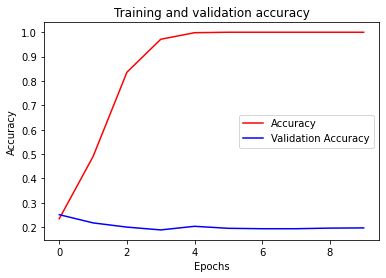

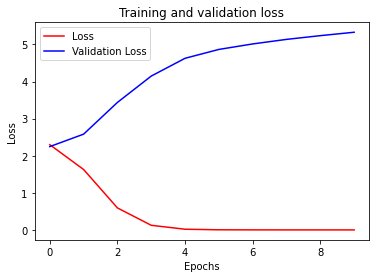

<Figure size 432x288 with 0 Axes>

In [45]:
train_pred ,test_pred ="","" # reset variables
plot(model_gru_att_history)
train_pred ,test_pred = prediction(model_gru_att)
print("GRU with attention model evaluation on training data:")
print("Accuracy Score: ",accuracy_score(y_train, train_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_train, train_pred))
print("Precision: ",precision_score(y_train, train_pred,average='micro'))
print("Recall:",recall_score(y_train, train_pred,average='micro'))
print("F1 score:",f1_score(y_train, train_pred,average='micro'))

print("GRU with attention model evaluation on test data:")
print("Accuracy Score: ",accuracy_score(y_test, test_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_test, test_pred))
print("Precision: ",precision_score(y_test, test_pred,average='micro'))
print("Recall:",recall_score(y_test, test_pred,average='micro'))
print("F1 score:",f1_score(y_test, test_pred,average='micro'))

In [68]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
print("GRU with attention layer:\nMultilabel Confusion Matrix:")
multilabel_confusion_matrix(y_test, test_pred,labels=np.unique(y_test))

GRU with attention layer:
Multilabel Confusion Matrix:


array([[[2511,   36],
        [  54,    2]],

       [[2221,  186],
        [ 171,   25]],

       [[2497,   48],
        [  54,    4]],

       [[2222,  180],
        [ 180,   21]],

       [[2589,    4],
        [  10,    0]],

       [[2585,    9],
        [   9,    0]],

       [[2585,    1],
        [  17,    0]],

       [[2570,    8],
        [  24,    1]],

       [[1767,  402],
        [ 309,  125]],

       [[1578,  459],
        [ 387,  179]],

       [[2039,  253],
        [ 252,   59]],

       [[1869,  330],
        [ 312,   92]],

       [[2514,   28],
        [  61,    0]],

       [[2471,   48],
        [  77,    7]],

       [[2502,   31],
        [  68,    2]],

       [[2444,   58],
        [  96,    5]]])

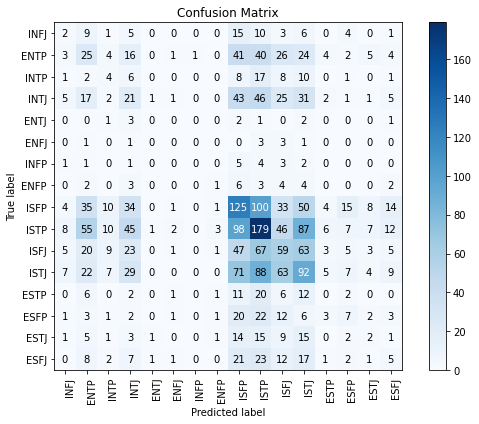

In [69]:
plot_confusion_matrix(y_test, test_pred, classes=df['type'].unique(),title='Confusion Matrix')

**LSTM WITH ATTENTION**

In [71]:
def lstm_attention_model():

    input_sequences = Input(shape=(MAX_LENGTH_FOR_KERAS_RNN,))

    embedding_layer = Embedding(input_dim=most_freq_words,
                                output_dim=embedding_vector_length,
                                input_length=MAX_LENGTH_FOR_KERAS_RNN,
                                trainable =True,
                                mask_zero =True,
                                weights=[word_embeddings_mbti])
       
    embout = embedding_layer(input_sequences)
    lstmout = LSTM(100, return_sequences=True)(embout)
    attout = attention_layer(lstmout)
    outputs = Dense(16, activation='softmax')(attout)
    model = Model(inputs=input_sequences, outputs=outputs)
    optimizer = Adam(lr=0.01, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
## RNN model initization
model_lstm_att = lstm_attention_model()
model_lstm_att.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 300)      3000000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 40, 100)      160400      embedding_4[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 40, 1)        101         lstm_1[0][0]                     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [72]:
model_lstm_att_history = model_lstm_att.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
76/76 [==============================] - 8s 53ms/step - loss: 2.3075 - accuracy: 0.1983 - val_loss: 2.2679 - val_accuracy: 0.2362
Epoch 2/10
76/76 [==============================] - 3s 35ms/step - loss: 1.9421 - accuracy: 0.3885 - val_loss: 2.4531 - val_accuracy: 0.1893
Epoch 3/10
76/76 [==============================] - 2s 32ms/step - loss: 1.0812 - accuracy: 0.6722 - val_loss: 3.0411 - val_accuracy: 0.2058
Epoch 4/10
76/76 [==============================] - 3s 34ms/step - loss: 0.3916 - accuracy: 0.8950 - val_loss: 3.9579 - val_accuracy: 0.1844
Epoch 5/10
76/76 [==============================] - 3s 34ms/step - loss: 0.1149 - accuracy: 0.9763 - val_loss: 4.9506 - val_accuracy: 0.1802
Epoch 6/10
76/76 [==============================] - 3s 35ms/step - loss: 0.0270 - accuracy: 0.9975 - val_loss: 5.8065 - val_accuracy: 0.2000
Epoch 7/10
76/76 [==============================] - 3s 34ms/step - loss: 0.0054 - accuracy: 0.9998 - val_loss: 6.3497 - val_accuracy: 0.1827
Epoch 8/10
76

LSTM with attention layer model evaluation on training data:
Accuracy Score:  0.8377799736495388
cohen_kappa_score: 0.8134233654844644
Precision:  0.8377799736495388
Recall: 0.8377799736495388
F1 score: 0.8377799736495388
LSTM with attention layer model evaluation on test data:
Accuracy Score:  0.19861698040722245
cohen_kappa_score: 0.06712687320410782
Precision:  0.19861698040722245
Recall: 0.19861698040722245
F1 score: 0.19861698040722245


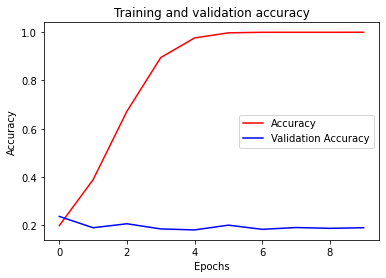

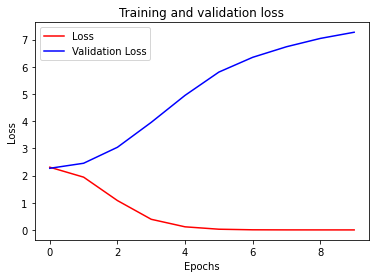

<Figure size 432x288 with 0 Axes>

In [73]:
train_pred ,test_pred ="","" # reset variables
plot(model_lstm_att_history)
train_pred ,test_pred = prediction(model_lstm_att) # 
print("LSTM with attention layer model evaluation on training data:")
print("Accuracy Score: ",accuracy_score(y_train, train_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_train, train_pred))
print("Precision: ",precision_score(y_train, train_pred,average='micro'))
print("Recall:",recall_score(y_train, train_pred,average='micro'))
print("F1 score:",f1_score(y_train, train_pred,average='micro'))

print("LSTM with attention layer model evaluation on test data:")
print("Accuracy Score: ",accuracy_score(y_test, test_pred))
print('cohen_kappa_score:',cohen_kappa_score(y_test, test_pred))
print("Precision: ",precision_score(y_test, test_pred,average='micro'))
print("Recall:",recall_score(y_test, test_pred,average='micro'))
print("F1 score:",f1_score(y_test, test_pred,average='micro'))

In [75]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix
print("LSTM with attention layer:\nMultilabel Confusion Matrix:")
multilabel_confusion_matrix(y_test, test_pred,labels=np.unique(y_test))

LSTM with attention layer:
Multilabel Confusion Matrix:


array([[[2516,   31],
        [  55,    1]],

       [[2245,  162],
        [ 175,   21]],

       [[2502,   43],
        [  56,    2]],

       [[2243,  159],
        [ 182,   19]],

       [[2589,    4],
        [  10,    0]],

       [[2593,    1],
        [   9,    0]],

       [[2582,    4],
        [  17,    0]],

       [[2559,   19],
        [  24,    1]],

       [[1777,  392],
        [ 309,  125]],

       [[1606,  431],
        [ 407,  159]],

       [[1982,  310],
        [ 236,   75]],

       [[1844,  355],
        [ 303,  101]],

       [[2529,   13],
        [  61,    0]],

       [[2461,   58],
        [  77,    7]],

       [[2494,   39],
        [  68,    2]],

       [[2437,   65],
        [  97,    4]]])

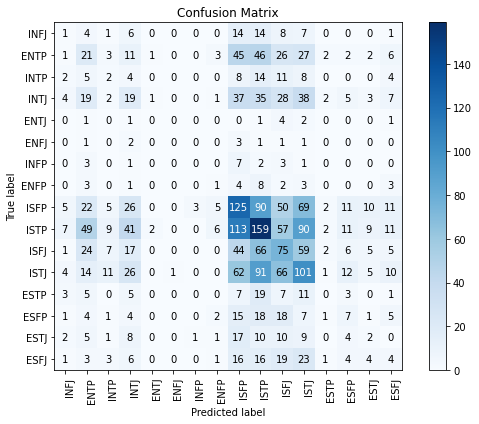

In [74]:
plot_confusion_matrix(y_test, test_pred, classes=df['type'].unique(),title='Confusion Matrix')